In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Device 설정(GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


### 1. 감성어 사전 기반 polarity 계산

In [ ]:
# 데이터프레임 불러오기(hanspell 맞춤법 교정, soynlp 정규화, kkma 품사 태깅)
df = pd.read_csv('/content/drive/MyDrive/BERT_modeling/pos_dataframe.csv')
df

,Unnamed: 0,id,rank,company,name1,name2,category,volume,alc,type,...,click,link,score,real_date,buy,real_review,split_sentences,sentence,words,normalized
0,0,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,162,https://cr.shopping.naver.com/adcr.nhn?x=c717o...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",상한 겁니까,상한 걸 ㅂ니까,상한 겁니까
1,1,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,162,https://cr.shopping.naver.com/adcr.nhn?x=c717o...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",구매확정합니다,구매 확정 하 ㅂ니다,구매확정합니다
2,2,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,162,https://cr.shopping.naver.com/adcr.nhn?x=c717o...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",올바른 상품이 왔더니 이건 도대체 다시는 여기 거 안 먹습니다,올바르 ㄴ 상품 이 오 았 더니 이 것 은 도대체 다시 는 여기 그 어 안 먹 습니다,올바른 상품이 왔더니 이건 도대체 다시는 여기 거 안 먹습니다
3,3,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,162,https://cr.shopping.naver.com/adcr.nhn?x=c717o...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",올바른 상태,올바르 ㄴ 상태,올바른 상태
4,4,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,162,https://cr.shopping.naver.com/adcr.nhn?x=c717o...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른 박스,저번 에 시키 ㄴ 박스 는 제품 상하 뒤집 지 말 아 달 란 스티커 와 올바르 ㄴ 박스,저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른 박스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305308,305634,147662,121,주로,골목막걸리 프리미엄 12,골목막걸리 프리미엄 12,막걸리/탁주,350,12.0,유리병,...,30,https://cr.shopping.naver.com/adcr.nhn?x=Nnk5d...,5,22.08.21.,우리술한잔,맛있네요 택배 포장 걱정했는데\n너무 만족으럽게 포장해 주셔서 잘 받았습니다.\n다...,"['맛있네요', '택배 포장 걱정했는데\n너무 만족으럽게 포장해 주셔서 잘 받았습니...",또르르,또르르,또르르
305309,305635,147663,121,주로,골목막걸리 프리미엄 12,골목막걸리 프리미엄 12,막걸리/탁주,350,12.0,유리병,...,30,https://cr.shopping.naver.com/adcr.nhn?x=Nnk5d...,5,22.06.07.,술마켓,꼼콤하게 잘 왔구요 걸쭉하니 만납니다.,"['꼼콤하게 잘 왔구요', '걸쭉하니 만납니다.']",꼼콤하게 잘 왔고요,꼬 ㅁ 콤 하 게 잘 오 았 고요,꼼콤하게 잘 왔고요
305310,305636,147663,121,주로,골목막걸리 프리미엄 12,골목막걸리 프리미엄 12,막걸리/탁주,350,12.0,유리병,...,30,https://cr.shopping.naver.com/adcr.nhn?x=Nnk5d...,5,22.06.07.,술마켓,꼼콤하게 잘 왔구요 걸쭉하니 만납니다.,"['꼼콤하게 잘 왔구요', '걸쭉하니 만납니다.']",걸쭉하니 만납니다,걸쭉 하 니 만나 ㅂ니다,걸쭉하니 만납니다
305311,305637,147664,121,주로,골목막걸리 프리미엄 12,골목막걸리 프리미엄 12,막걸리/탁주,350,12.0,유리병,...,30,https://cr.shopping.naver.com/adcr.nhn?x=Nnk5d...,5,22.07.06.,술마켓,따봉 맛있어요 얼음 넣으면 신의한수,"['따봉 맛있어요', '얼음 넣으면 신의한수']",따봉 맛있어요,따 아 봉 맛있 어요,따봉 맛있어요


In [ ]:
# 품사태깅 이뤄지지 않은 결측값 drop
df = df.dropna(subset=['words'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305260 entries, 0 to 305312
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       305260 non-null  int64  
 1   id               305260 non-null  int64  
 2   rank             305260 non-null  int64  
 3   company          305260 non-null  object 
 4   name1            305260 non-null  object 
 5   name2            305260 non-null  object 
 6   category         305260 non-null  object 
 7   volume           305260 non-null  int64  
 8   alc              305260 non-null  float64
 9   type             305260 non-null  object 
 10  price            305260 non-null  int64  
 11  review_num       305260 non-null  int64  
 12  click            305260 non-null  int64  
 13  link             305260 non-null  object 
 14  score            305260 non-null  int64  
 15  real_date        305260 non-null  object 
 16  buy              305260 non-null  obje

In [ ]:
# 감성어 사전 불러오기
sentiword_dic = pd.read_csv('/content/drive/MyDrive/BERT_modeling/sentiment_dic.csv')
sentiword_dic.head()

,Unnamed: 0,word_root,polarity
0,0.0,가격,1.5
1,1.0,가까스로,0.0
2,2.0,가까이,1.5
3,3.0,가꾸러뜨리,-1.5
4,4.0,가꾸러트리,-1.5


In [ ]:
idx = 0
polarities = []

# Use tqdm to track the progress of the sentiment analysis loop -> 2시간 30분
with tqdm(total=len(df)) as pbar:
    for token in df['words']:
        if pd.notna(token):
            polarity = 0
            for i in range(len(sentiword_dic)):
                if sentiword_dic['word_root'][i] in token:
                    polarity += sentiword_dic['polarity'][i]
            polarities.append(polarity)
        else:
            polarities.append(0)
        idx += 1
        pbar.update(1)

100%|██████████| 305260/305260 [2:03:34<00:00, 41.17it/s]


### 2. sentiment 라벨링
* polarity 값 0 기준으로 'positive', 'negative' 라벨링

In [ ]:
# Calculate the average sentiment value
# average = sum(polarities) / len(polarities)
average = 0
# Assign sentiment labels based on the average sentiment value
polarities = df.polarity.to_list()
sentiments = ['positive' if polarity >= average else 'negative' for polarity in polarities]

# Print the sentiments list
print(average)
print(polarities[:10])
print(sentiments[:10])

0
[-6.0, 0.0, 4.5, 3.0, 3.0, -3.0, -1.5, 4.5, 0.0, -6.0]
['negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative']


In [ ]:
df['polarity'] = polarities
df['sentiment'] = sentiments
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305260 entries, 0 to 305259
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0.1     305260 non-null  int64  
 1   Unnamed: 0       305260 non-null  int64  
 2   id               305260 non-null  int64  
 3   rank             305260 non-null  int64  
 4   company          305260 non-null  object 
 5   name1            305260 non-null  object 
 6   name2            305260 non-null  object 
 7   category         305260 non-null  object 
 8   volume           305260 non-null  int64  
 9   alc              305260 non-null  float64
 10  type             305260 non-null  object 
 11  price            305260 non-null  int64  
 12  review_num       305260 non-null  int64  
 13  click            305260 non-null  int64  
 14  link             305260 non-null  object 
 15  score            305260 non-null  int64  
 16  real_date        305260 non-null  obje

### 3. 결과 확인

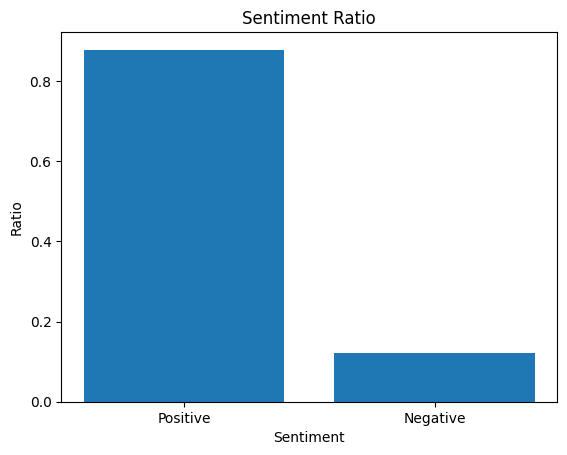

In [ ]:
# 긍부정별 리뷰 개수 비율 계산
sentiment_counts = df['sentiment'].value_counts()
positive_ratio = sentiment_counts['positive'] / df.shape[0]
negative_ratio = sentiment_counts['negative'] / df.shape[0]

# 그래프 생성
plt.bar(['Positive', 'Negative'], [positive_ratio, negative_ratio])
plt.xlabel('Sentiment')
plt.ylabel('Ratio')
plt.title('Sentiment Ratio')
plt.show()

In [ ]:
df['sentiment'].value_counts()

positive    268025
negative     37235
Name: sentiment, dtype: int64